In [1]:
import sys
sys.path.append("../")
sys.path.append("../../")
from Helpers.getHybridsFromIDFile import *
import json
import glob
from Helpers.getECSubtypes import *
from plots.ResponseCurvePlots import *

In [2]:
jsonPath = "../Helpers/jsonFiles/"
jsonFiles = glob.glob(jsonPath + "*.json")
hybrids = {}
subtypes = getECSubtypes()
for subtype in subtypes:
    for jsonFile in jsonFiles:
        if subtype in jsonFile:
            _, hybrids[subtype] = getHybridsFromIDFile(jsonFile, verbose=False)

Hybrid 0 bugged: True
Hybrid 1 bugged: False
Hybrid 2 bugged: False
Hybrid 3 bugged: False
Hybrid 4 bugged: False
Hybrid 5 bugged: False
Hybrid 6 bugged: False
Hybrid 7 bugged: False
Hybrid 8 bugged: False


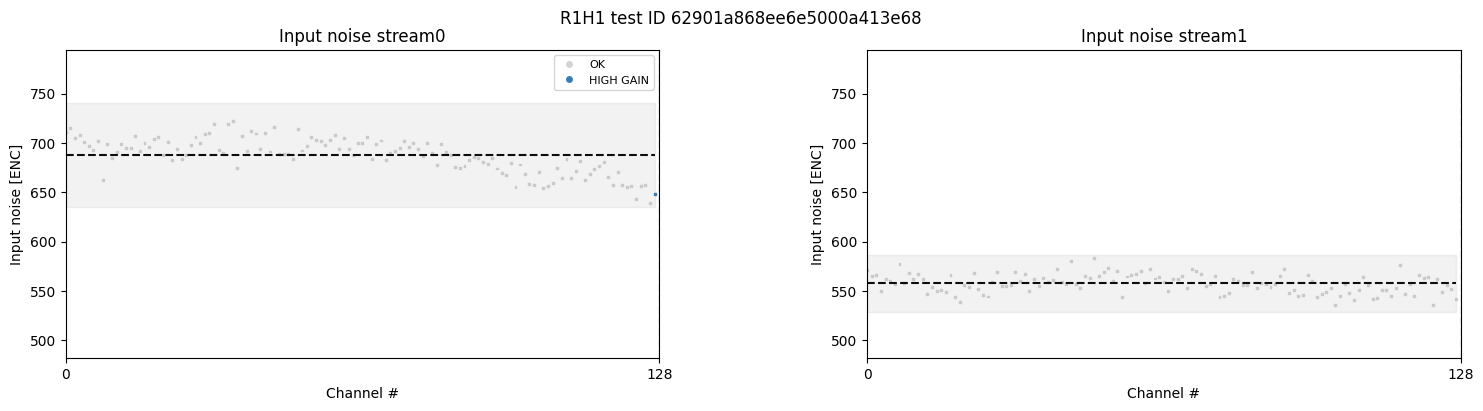

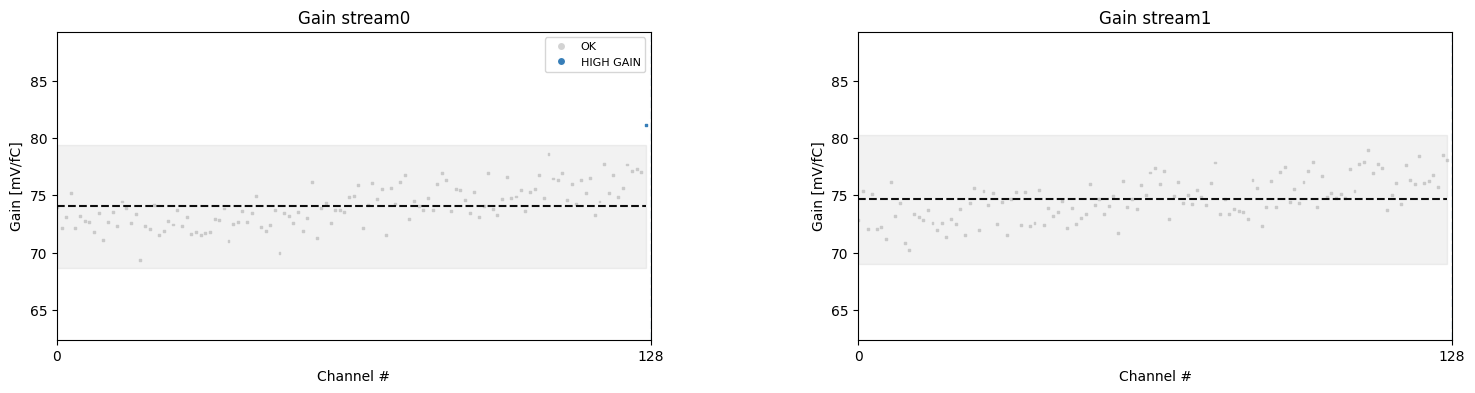

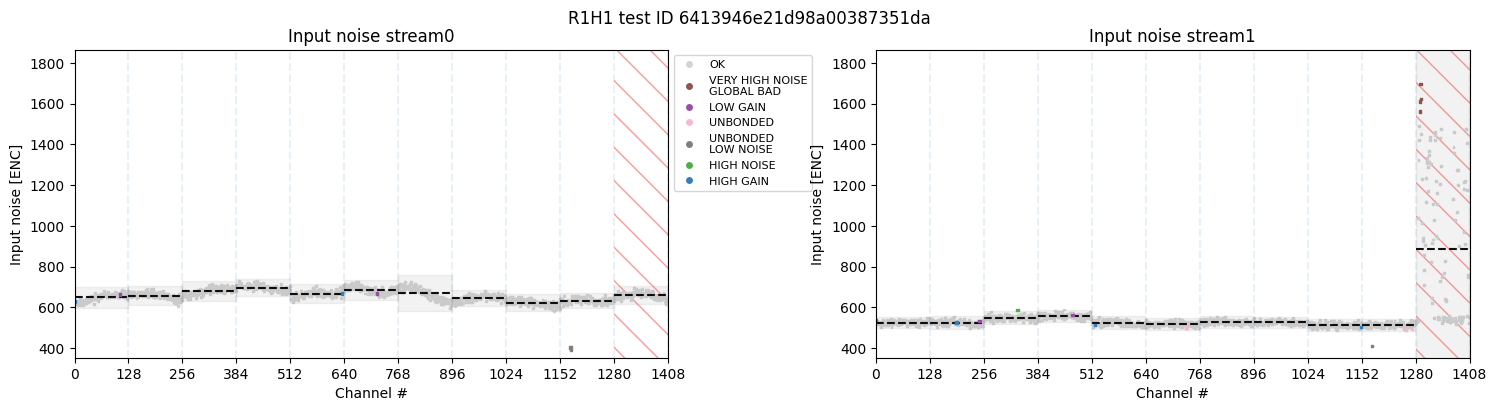

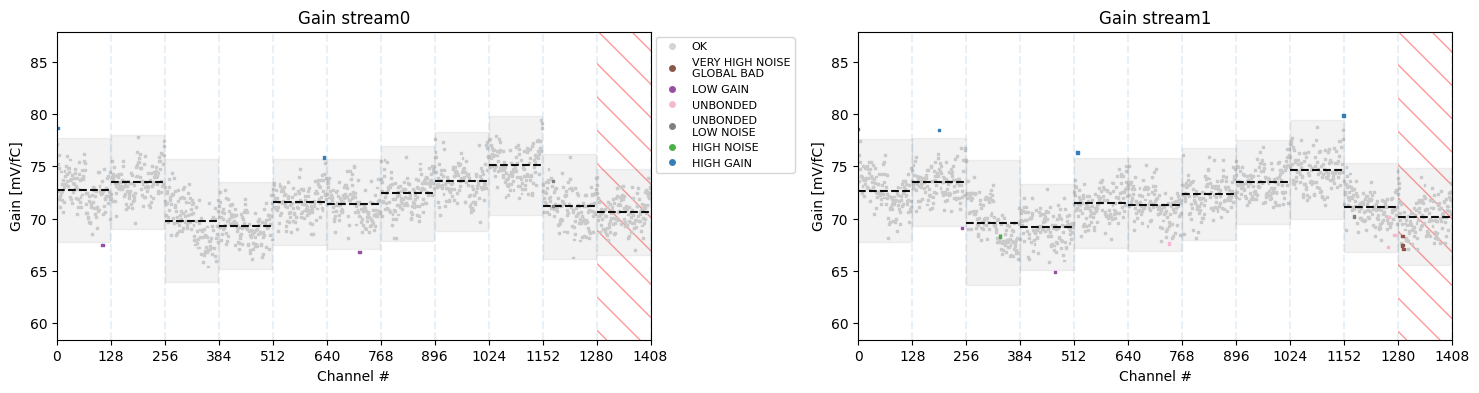

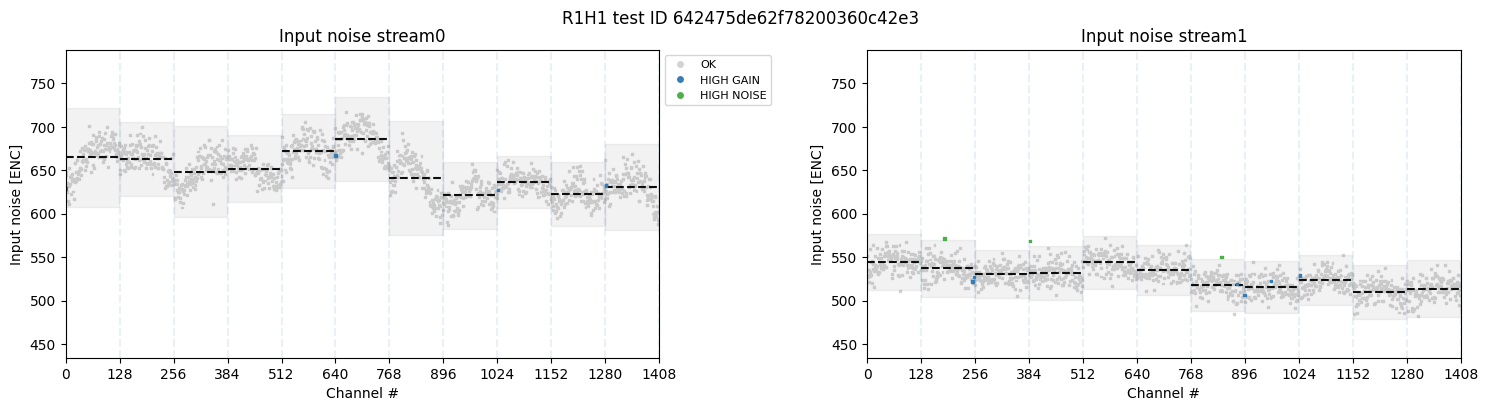

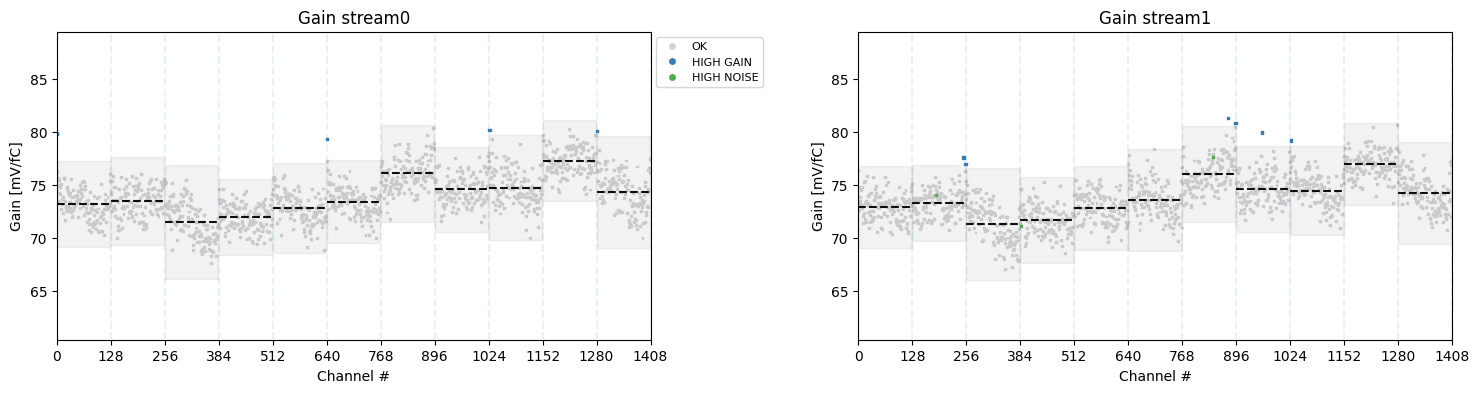

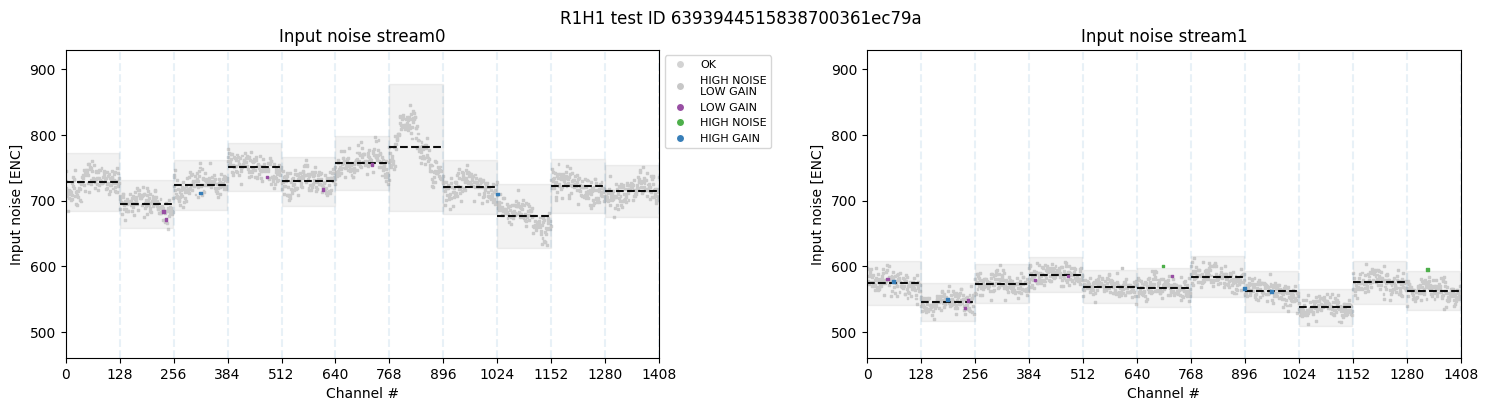

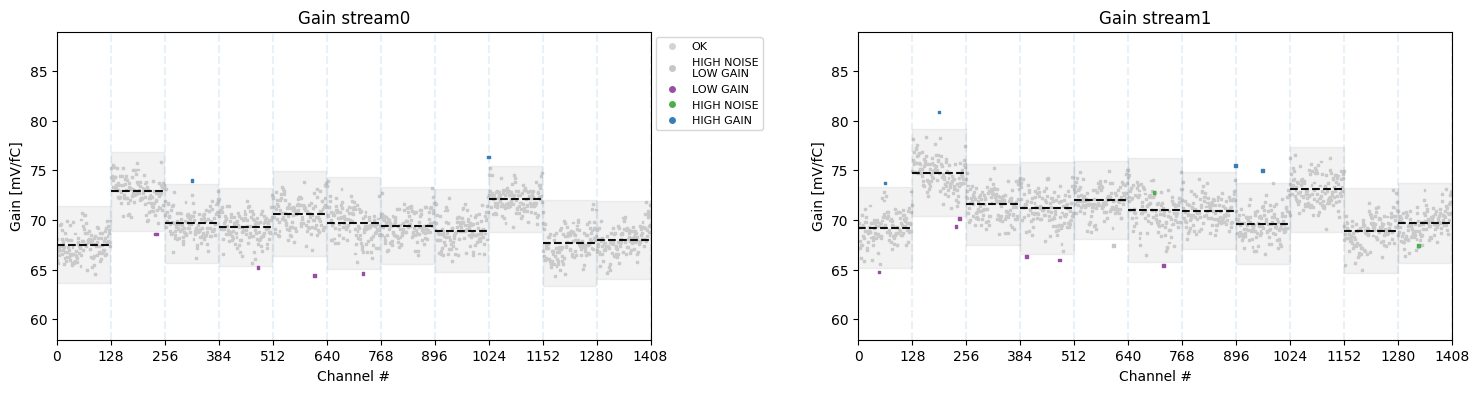

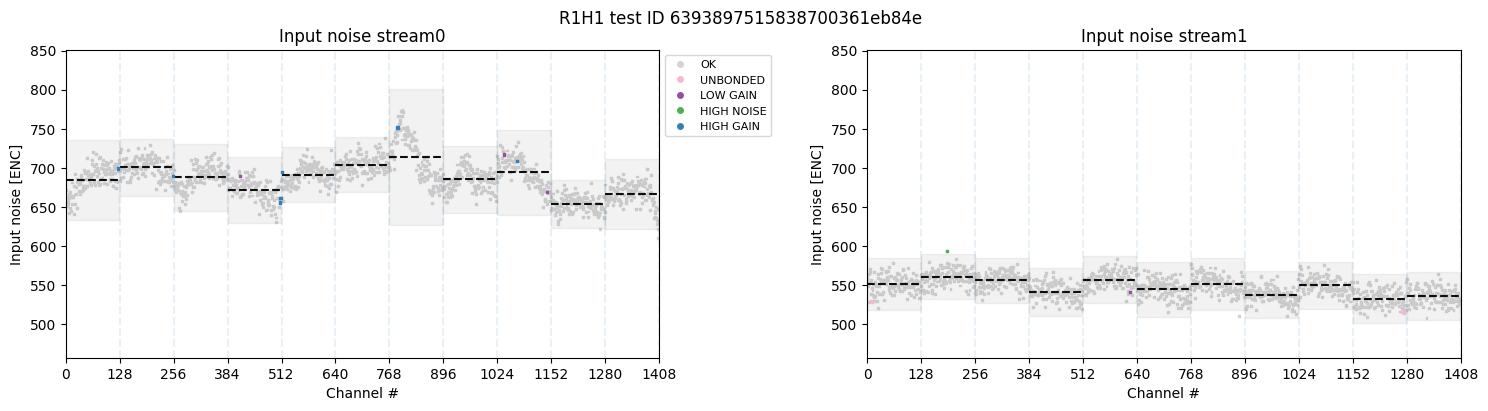

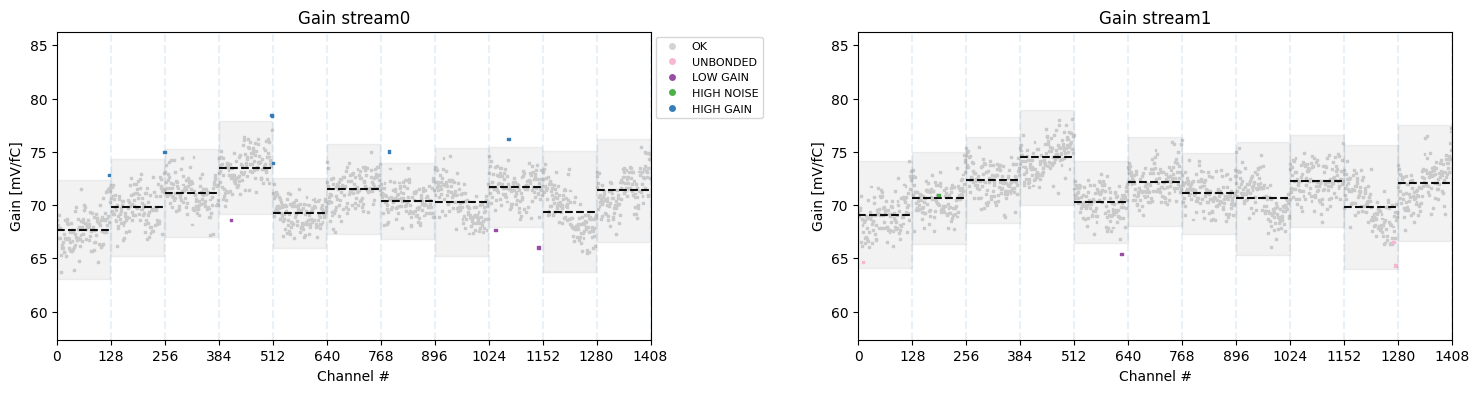

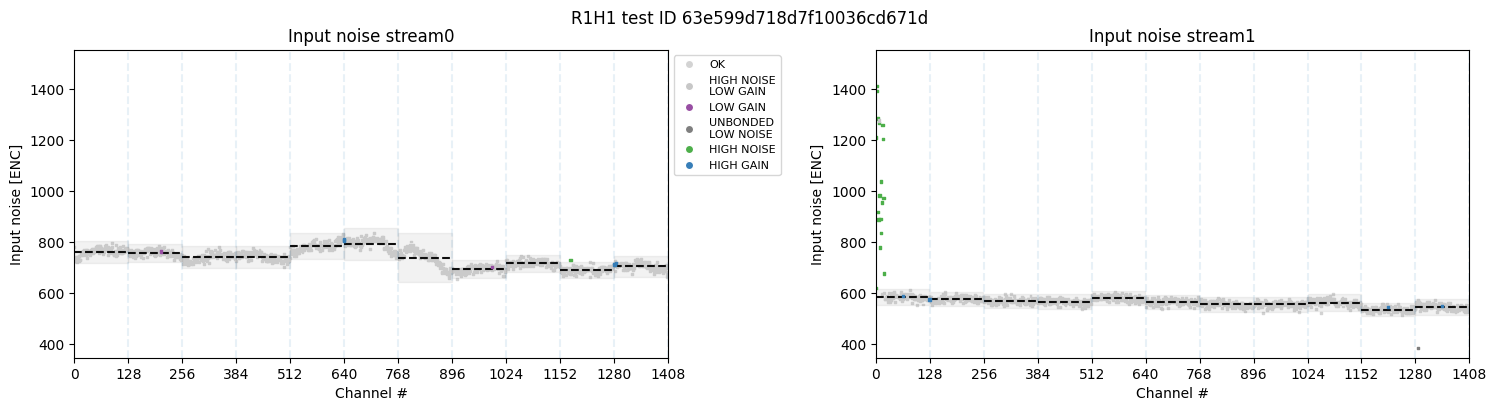

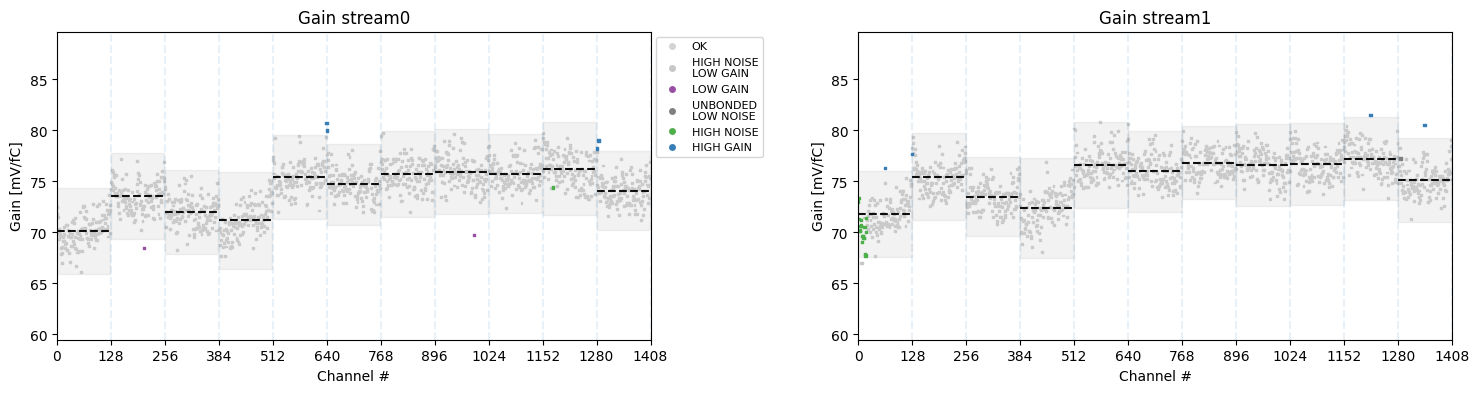

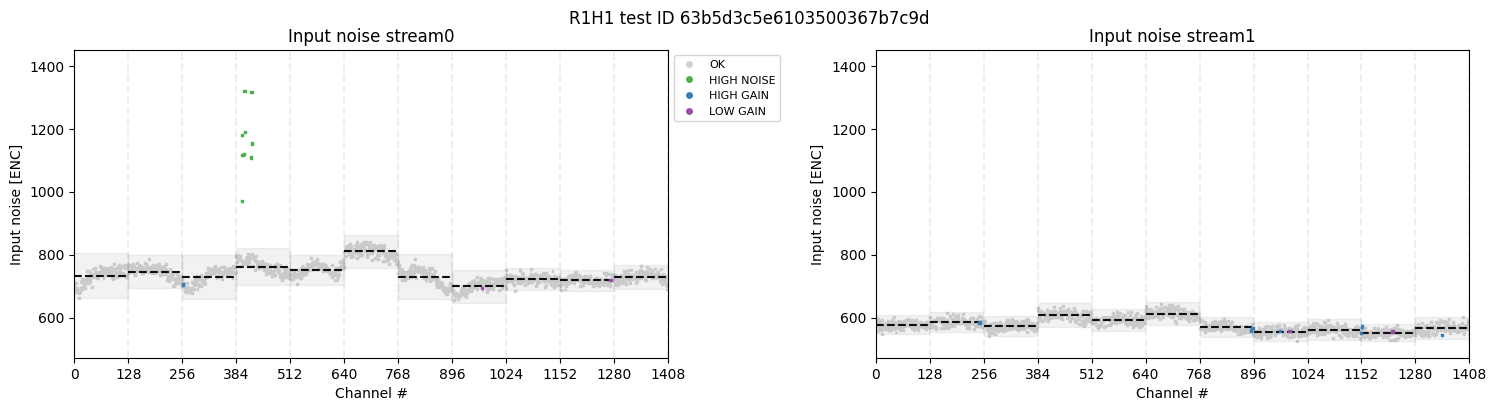

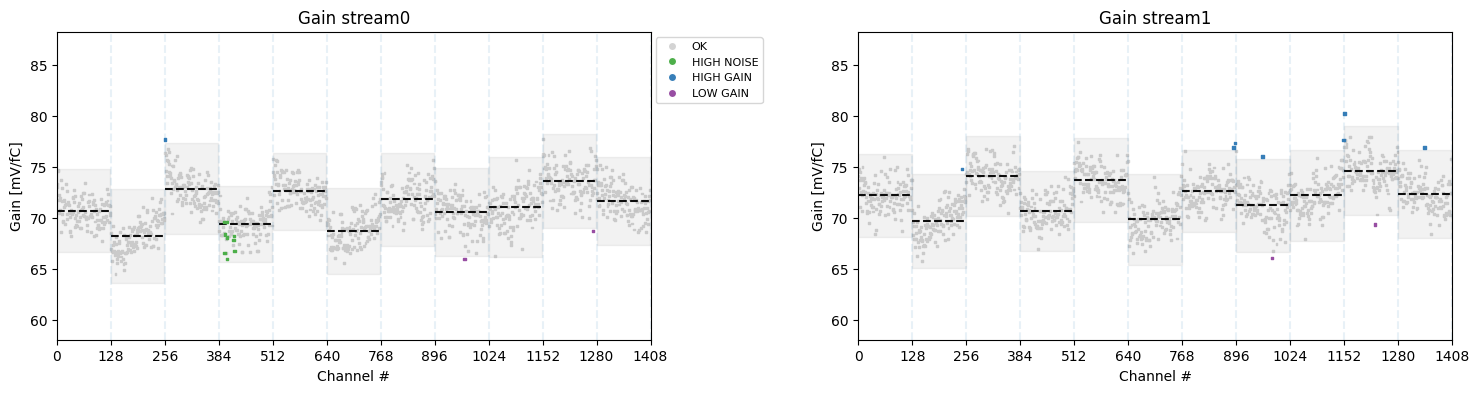

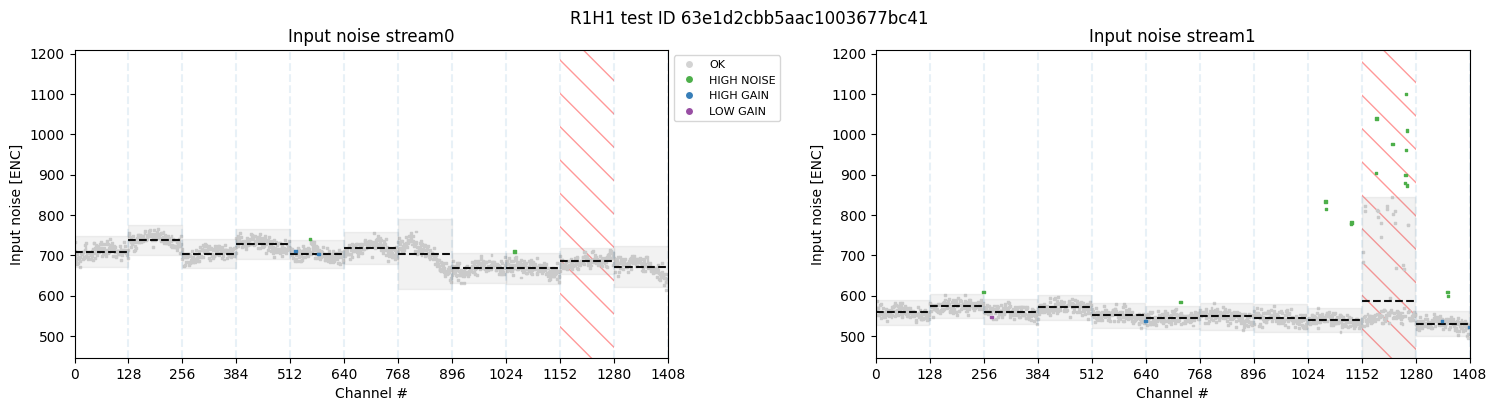

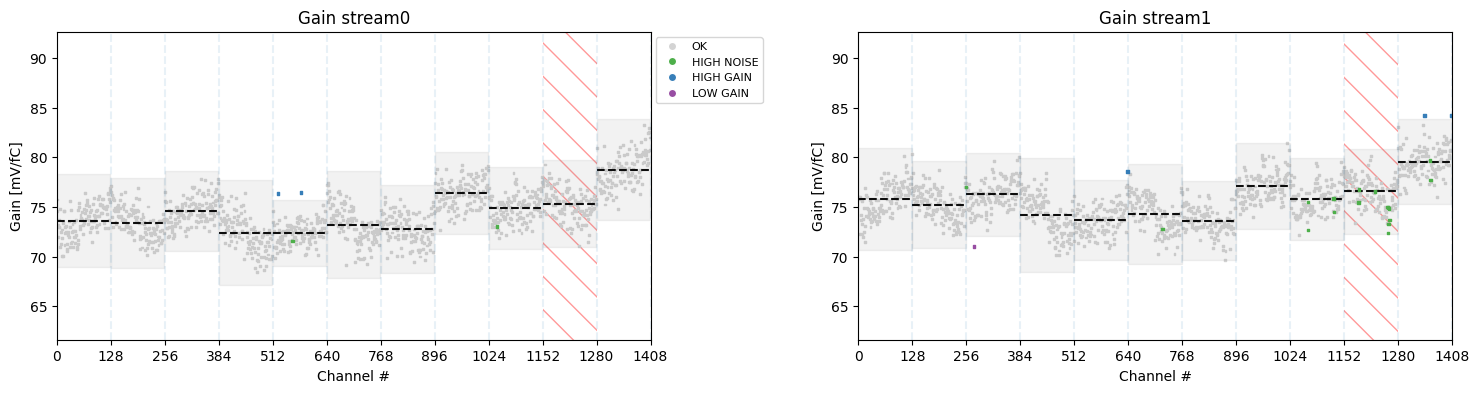

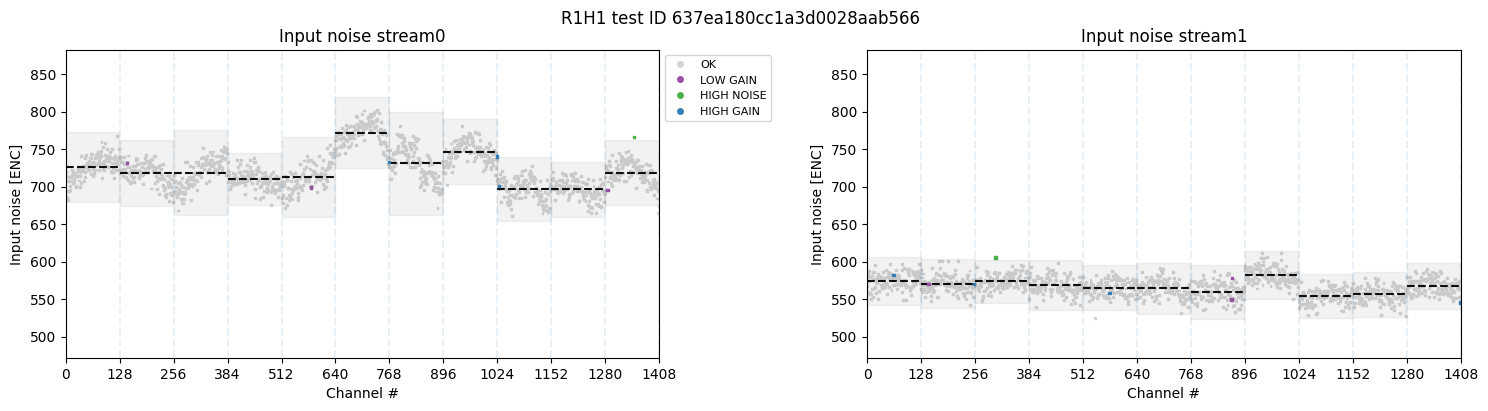

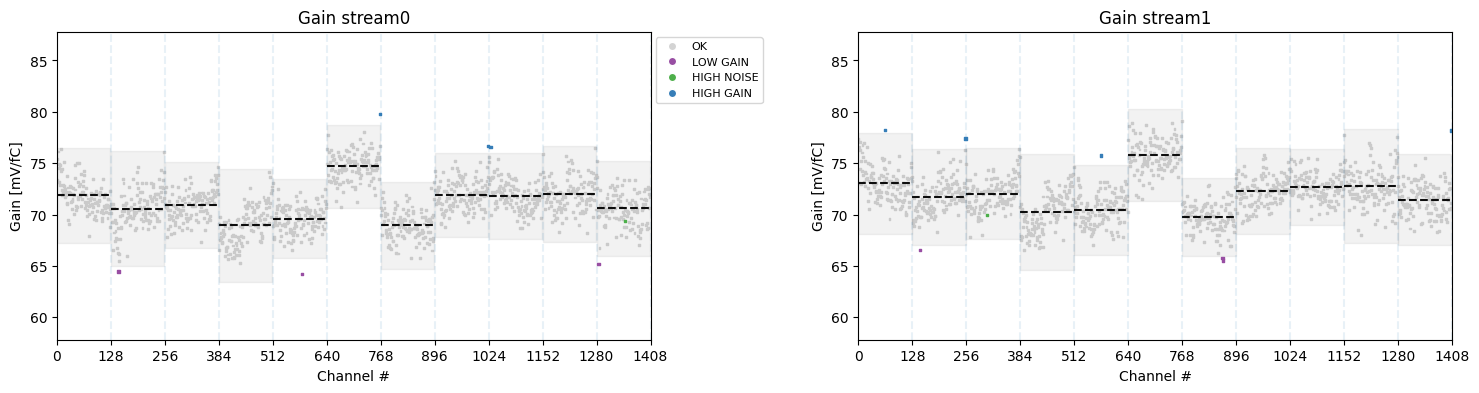

In [10]:
for h, hybrid in enumerate(hybrids["R1H1"]):
    print("Hybrid", h, "bugged:", len(hybrid.chips) == 1)
    hybrid.classification(strategy="NathanR0Revised")
    fig, _ = plotRCClassified(hybrid, variable="innse", showStats=True);
    fig.suptitle(str(hybrid.subtype) + " test ID " + str(hybrid.testID))
    plotRCClassified(hybrid, variable="gain", showStats=True);

In [6]:
# Function to find the key path to given value in a dictionary
def findValue(dct, value):
    if isinstance(dct, dict):
        for key in dct:
            if isinstance(dct[key], str):
                if value in dct[key]:
                    return key
            elif value == dct[key]:
                return key
            found = findValue(dct[key], value)
            if found is not None:
                if isinstance(found, list):
                    found =  [key] + found
                else:
                    found = [key, found]
                return found
        return None
    
    elif isinstance(dct, list):
        for key, item in enumerate(dct):
            if isinstance (item, dict) or isinstance(item, list):
                found = findValue(item, value)
                if found is not None:
                    if isinstance(found, list):
                        found = [key] + found
                    else:
                        found = [key, found]
                    return found
            else:
                if isinstance(item, str):
                    if value in item:
                        return key
                elif value == item:
                    return key
        return None
    
    else:
        if isinstance(dct, str):
            if value in dct:
                return True
        elif value == dct:
            return True
        return None

In [7]:
import json
import glob

In [8]:
resultJsons = glob.glob("../../data/*.json")
results = []
for resultJson in resultJsons:
    with open(resultJson, "r") as f:
        results.append(json.load(f))

In [9]:
keyDict = {}
for r, result in enumerate(results):
    keys = findValue(result, "PPB")
    if keys:
        keyDict[r] = keys

In [10]:
PPBresults = []
PPBjsons = []
for key in keyDict:
    PPBresults.append(results[key])
    PPBjsons.append(resultJsons[key])

In [11]:
PPAjsons = []
for i in range(len(resultJsons)):
    if i not in list(keyDict.keys()):
        PPAjsons.append(resultJsons[i])

In [12]:
for js in PPAjsons:
    with open(js, "r") as f:
        result = json.load(f)
    PPBcheck = findValue(result, "PPB")
    if PPBcheck:
        print(PPBcheck)

In [13]:
len(PPAjsons), len(PPBjsons), len(results)

(187, 64, 251)

In [14]:
import sys
sys.path.append("../../")
from parsers.RCparsers import parseRC

In [15]:
hybrids = {}
for r, result in enumerate(PPBresults):
    subtype = result['components'][0]['type']['code']
    if not subtype in list(hybrids.keys()):
        hybrids[subtype] = []
    hybrids[subtype].append(parseRC(PPBjsons[r], verbose=False))

In [16]:
PPAhybrids = {}
for r, js in enumerate(PPAjsons):
    with open(js, "r") as f:
        result = json.load(f)
    subtype = result['components'][0]['type']['code']
    if not subtype in list(PPAhybrids.keys()):
        PPAhybrids[subtype] = []
    PPAhybrids[subtype].append(parseRC(PPAjsons[r], verbose=False))

In [17]:
import matplotlib.pyplot as plt
import numpy as np

In [18]:
len(hybrids), len(PPAhybrids)

(9, 13)

Text(0.5, 1.0, 'PPB')

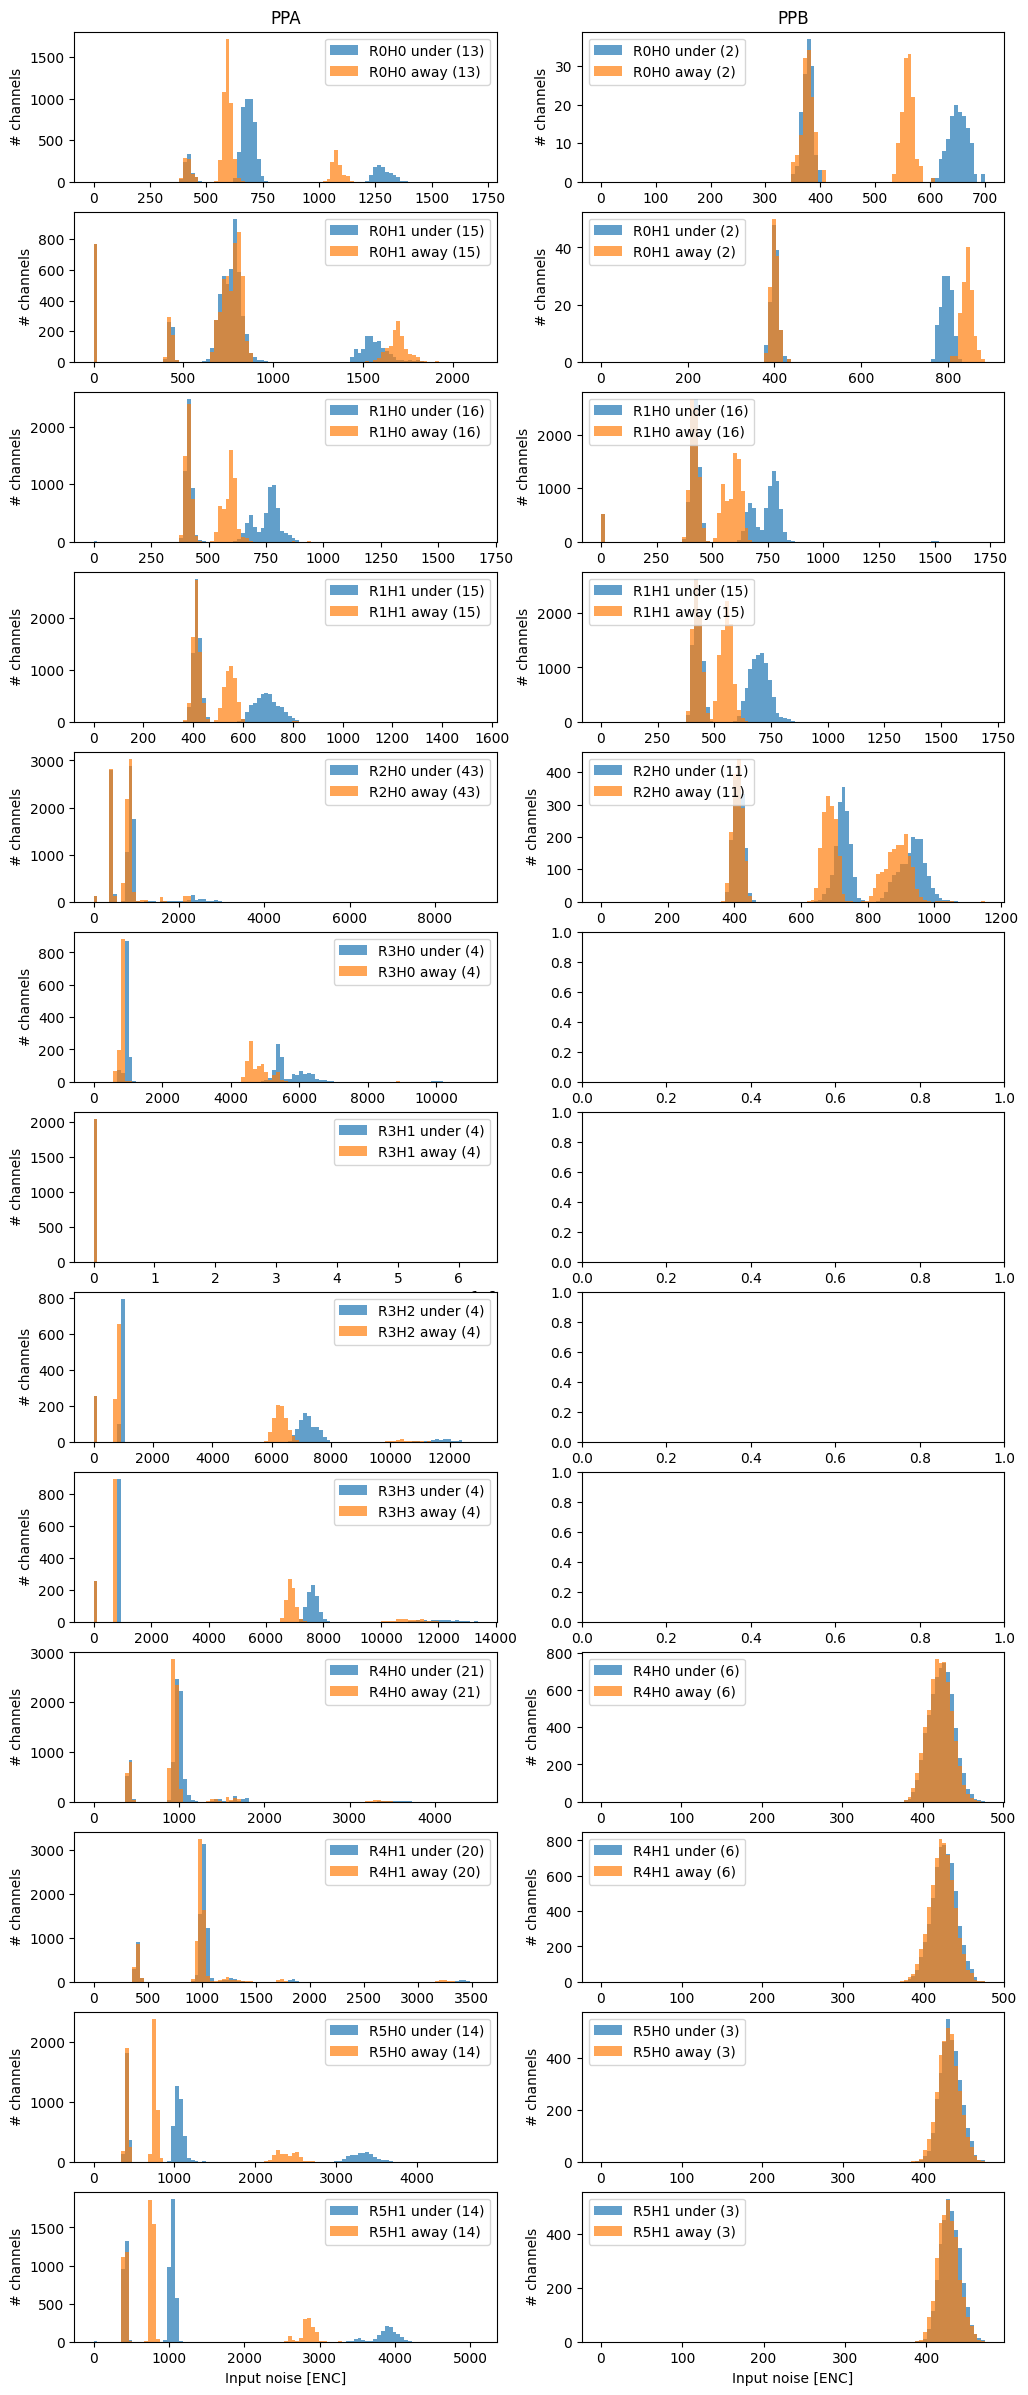

In [22]:
fig, axs = plt.subplots(max(len(hybrids), len(PPAhybrids)), 2, figsize=(12, 30))
subtypes = list(PPAhybrids.keys())
subtypes.sort()
for s, subtype in enumerate(subtypes):
    if subtype in hybrids.keys():
        innses = {0 : [], 1 : []}
        minValue = 1000000
        maxValue = -1000000
        for stream in [0, 1]:
            for hybrid in hybrids[subtype]:
                innses[stream].extend([channel.innse for channel in hybrid.getStream(stream)])

            minValue = min(minValue, np.min(innses[stream]))
            maxValue = max(maxValue, np.max(innses[stream]))
        bins = np.linspace(0, maxValue, 100)
        for stream in [0, 1]:
            axs[s, 1].hist(innses[stream], alpha=0.7, bins=bins,
                           label=subtype + " " + {0 : "under", 1 : "away"}[stream] + " (" + str(len(hybrids[subtype])) + ")")
        axs[s, 1].set_ylabel("# channels")
        axs[s, 1].set_xlabel("Input noise [ENC]")
        axs[s, 1].legend(loc="upper left")
    if subtype in PPAhybrids.keys():
        innses = {0 : [], 1 : []}
        minValue = 1000000
        maxValue = -1000000
        for stream in [0, 1]:
            for hybrid in PPAhybrids[subtype]:
                innses[stream].extend([channel.innse for channel in hybrid.getStream(stream)])

            minValue = min(minValue, np.min(innses[stream]))
            maxValue = max(maxValue, np.max(innses[stream]))
        bins = np.linspace(0, maxValue, 100)
        for stream in [0, 1]:
            axs[s, 0].hist(innses[stream], alpha=0.7, bins=bins,
                           label=subtype + " " + {0 : "under", 1 : "away"}[stream] + " (" + str(len(PPAhybrids[subtype])) + ")")
        axs[s, 0].set_ylabel("# channels")
        axs[s, 0].set_xlabel("Input noise [ENC]")
        axs[s, 0].legend()
axs[0, 0].set_title("PPA")
axs[0, 1].set_title("PPB")

In [30]:
a = (1, 2)
b, c = a

In [265]:
b, c

(1, 2)

In [266]:
b

1